In [33]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.fake_provider import FakeVigoV2
from matplotlib import pyplot as plt
import os
import sys
import numpy as np

sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "pauli_lindblad_per"))

from tomography.experiment import SparsePauliTomographyExperiment as tomography
from primitives.pauli import QiskitPauli

plt.style.use("ggplot")

In [34]:
backend = FakeVigoV2()

In [35]:
def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(2*n)
    trotterLayer.rx(dt*4*h, range(2*n))
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [2*i+1 for i in range(n)])
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [2*i+2 for i in range(n-1)])
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .2
n = 2

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(n*2)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    transpiled = transpile(trotterCircuit, backend)
    return transpiled

circuits = [maketrotterCircuit(i) for i in range(1,15)]

In [36]:
def executor(circuits):
    return backend.run(circuits).result().get_counts()

In [37]:
experiment = tomography(circuits = circuits, inst_map = [0,1,2,3,4], backend = backend)

In [38]:
experiment.generate(samples = 8, single_samples = 10, depths = [2,4,8,16])

In [39]:
experiment.run(executor)

In [40]:
noisedataframe = experiment.analyze()

In [41]:
perexp = experiment.create_per_experiment(circuits)

In [42]:
expectations = ["ZIIII","IZIII","IIZII","IIIZI"]
perexp.generate(expectations = expectations, samples = 10, noise_strengths = [0,0.5,1,2])

## PER

In [43]:
perexp.run(executor)

In [44]:
circuit_results = perexp.analyze()

In [45]:
results = []
results_at_noise = []
for run in circuit_results:
    tot = 0
    tot_at_noise = array = [0 for _ in range(len(run.get_result(expectations[0]).get_strengths()))]
    for op in expectations:
        expec = run.get_result(op).expectation
        expec_at_noise = run.get_result(op).get_expectations()
        tot += expec
        for i in range(0,len(tot_at_noise)):
            tot_at_noise[i] += expec_at_noise[i]/4
    results.append(tot/4)
    results_at_noise.append(tot_at_noise)

In [46]:
results_at_noise[0]

[0.7725855608440776,
 0.5754223710619952,
 0.6815074742859368,
 0.6753093411714488]

In [47]:
for run in circuit_results:
    print(run.get_result(expectations[0]).get_strengths(), run.get_result(expectations[0]).get_expectations())

[0, 0.5, 1, 2] [0.7775529077981783, 0.5678017287686419, 0.6975567932642999, 0.6839449074755939]
[0, 0.5, 1, 2] [-0.048596656816025555, -0.06127908534318668, -0.028480253342523205, -0.019056640104188317]
[0, 0.5, 1, 2] [-0.42504045870588214, -0.8187518539286218, -0.6688671262942582, -0.6709612625694437]
[0, 0.5, 1, 2] [-1.1804968781097505, -0.6692221176061617, -0.8851914035209234, -0.7178699151335995]
[0, 0.5, 1, 2] [-0.3947409903162219, -0.6164702052342912, -0.5622755898873147, -0.5786098528337618]
[0, 0.5, 1, 2] [0.2965948212489197, 0.10015498808778597, 0.08774430993027368, 0.0490027888393414]
[0, 0.5, 1, 2] [0.9055695385614755, 0.9555714688249303, 0.5846828480317999, 0.3662644345299491]
[0, 0.5, 1, 2] [0.8340992718996603, 0.00035196686884610975, 0.7476066502412341, 0.7390206915129733]
[0, 0.5, 1, 2] [0.7961415998363839, 0.10929036571158335, 0.44626044024203637, 0.359772612076874]
[0, 0.5, 1, 2] [-0.38575808482534446, -0.13906103922815108, -0.1000997139538683, 0.01947546735922543]
[0,

In [48]:
circuit_results[-1]._per_circ.overhead(0)

6.15515447490346

In [49]:
noisyresult = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= backend.run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    noisyresult.append(tot/(1024*n*2))

Text(0, 0.5, 'Z Magnetization')

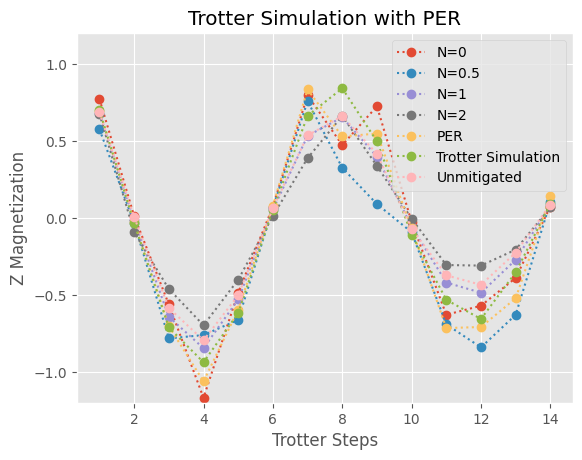

In [50]:
res = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= Aer.get_backend('qasm_simulator').run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    res.append(tot/(1024*n*2))

plt.plot(range(1,15), [res[0] for res in results_at_noise], 'o:')
plt.plot(range(1,15), [res[1] for res in results_at_noise], 'o:')
plt.plot(range(1,15), [res[2] for res in results_at_noise], 'o:')
plt.plot(range(1,15), [res[3] for res in results_at_noise], 'o:')
plt.plot(range(1,15), results, 'o:')
plt.plot(range(1,15), res, 'o:')
plt.plot(range(1,15), noisyresult, 'o:')
plt.ylim([-1.2,1.2])
plt.legend(["N=0", "N=0.5", "N=1", "N=2", "PER", "Trotter Simulation", "Unmitigated"])
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")

Text(0.5, 1.0, 'Expectation vs Noise Strength IIIZ')

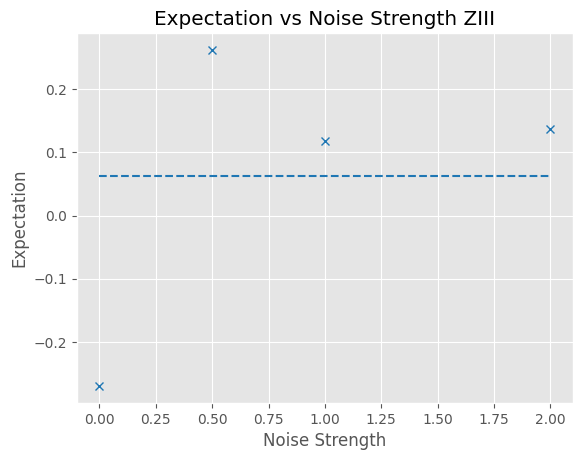

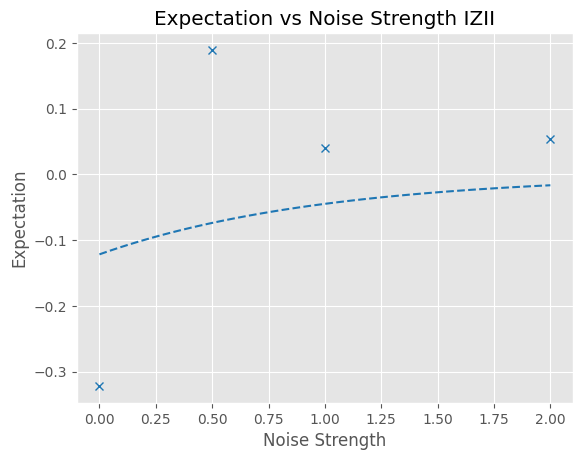

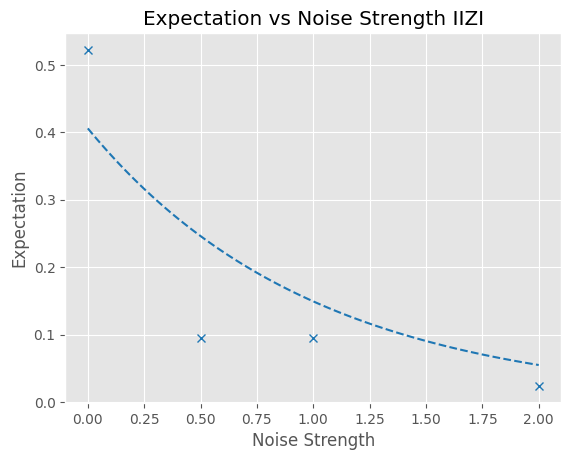

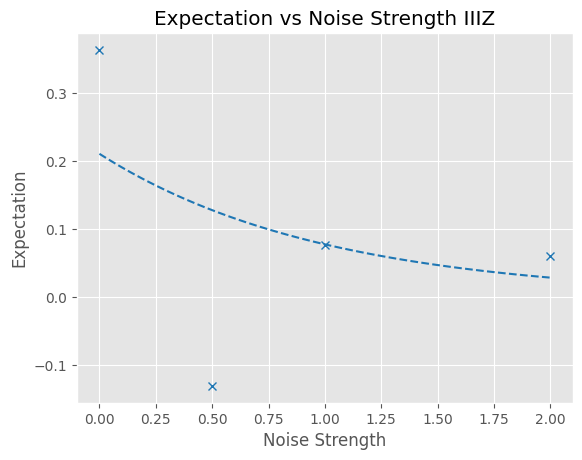

In [51]:
ax = circuit_results[-1].get_result("ZIIII").plot()
plt.title('Expectation vs Noise Strength ZIII')
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
circuit_results[-1].get_result("IZIII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IZII')
circuit_results[-1].get_result("IIZII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIZI')
circuit_results[-1].get_result("IIIZI").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIIZ')

## Analysis

In [52]:
layer1 = experiment.analysis.get_layer_data(0)

<Axes: >

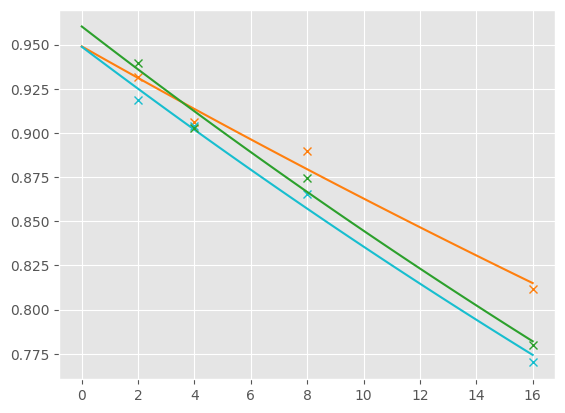

In [53]:
layer1.graph((1,))

<Axes: >

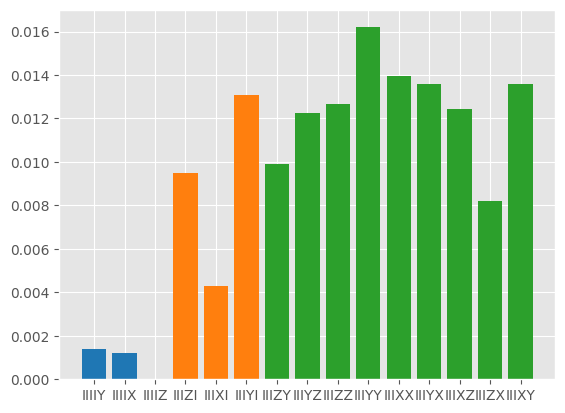

In [54]:
layer1.plot_infidelitites((0,),(1,),(0,1))

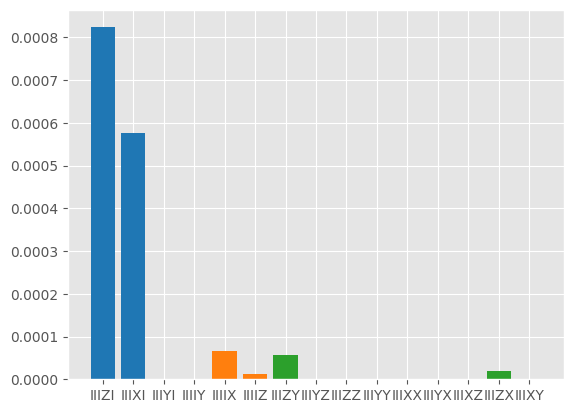

In [55]:
layer1.plot_coeffs((1,),(0,),(0,1))

In [56]:
import pickle
with open("graph.pickle", "wb") as f:
    pickle.dump(results, f)